In [ ]:
#Random Forest trained with non-linear data, with data augmentation SAME for each label and using labels-v4
#Trained without new features: Objective function size

In [1]:
import numpy as np
import pandas as pd
import random
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import os
import time

In [2]:
# nombre de instancia
# número restricciones
# número variables
# si es lineal o no (true / false)
# porcentaje de restricciones unarias, binarias, porcentaje de ternarias, porcentaje cuaternarias o más 
# porcentaje de terminos unarios, binarios, porcentaje de ternarios, porcentaje cuaternarios o más 
# porcentaje de terminos positivos/negativos en restricciones
# porcentaje de terminos positivos/negativos en funcion obj
# timestep
# solver (label)

main_path="/global/scratch/users/cpezov/AAPBO/"
d_path=main_path+"datasets-v4/"

columns = ["# constraints","# variables","linearity","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% degree 1 terms","% degree 2 terms","% degree 3 terms","% degree 4+ terms","% positive in constr","% positive in obj func","timestep","solver"]

df = pd.read_csv(main_path+"data_features.csv", usecols=columns)
solvers=df["solver"].to_list()

In [3]:
x=df[["# constraints","# variables","linearity","% 1 term constr","% 2 terms constr","% 3 terms constr","% 4+ terms constr","% degree 1 terms","% degree 2 terms","% degree 3 terms","% degree 4+ terms","% positive in constr","% positive in obj func","timestep"]]
y=df[['solver']]

#agrupar diferentes timestpes de cada instancia en un mismo set
random.seed(9) #same seed to generate same random numbers as other models
train_indx=[]
inst_train=[]
test_indx=[]
for i in range(0,3128): # v4
    r = random.randint(0,2)
    if(r==2):
        for j in range(0,500):
            test_indx.append(500*i+j)
    else:
        inst_train.append(i)
        for j in range(0,500):
            train_indx.append(500*i+j)

x_train=x.iloc[train_indx]
x_test=x.iloc[test_indx]
y_train=y.iloc[train_indx]
y_test=y.iloc[test_indx]
y_train_og=y.iloc[train_indx]

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1027000, 14)
(537000, 14)
(1027000, 1)
(537000, 1)


In [4]:
#Data augmentation para training set de instancias con clases distintas a gurobi (5)

indx_dis=[] #indexes of instances with disadvantaged labels 

#identificar instancias que tengan clase distinta a gurobi
for i in inst_train:
    has_dis=False
    for j in range(500):
        ind=500*i+j
        if(solvers[ind]!=5):
            has_dis=True
            break
    if(has_dis):
        for j in range(500):
            indx_dis.append(500*i+j)

print(len(indx_dis))
print(len(train_indx), end="\n\n")            

#agregar las instancias al final de x_train e y_train
x_train_dis=x.iloc[indx_dis]
y_train_dis=y.iloc[indx_dis]

x_train=pd.concat([x_train,x_train_dis])
y_train=pd.concat([y_train,y_train_dis])

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

674500
1027000

(1701500, 14)
(537000, 14)
(1701500, 1)
(537000, 1)


In [5]:
rf_model = RandomForestClassifier(n_estimators=100, max_features="sqrt", criterion="gini",random_state=3)
rf_model.fit(np.nan_to_num(x_train.astype(np.float32)), y_train.values.ravel())

RandomForestClassifier(random_state=3)

In [6]:
y_pred = rf_model.predict(np.nan_to_num(x_test.astype(np.float32)))

In [7]:
print("Accuracy",metrics.accuracy_score(y_test.values.ravel(), y_pred))
pred = rf_model.predict_proba(np.nan_to_num(x_test.astype(np.float32)))
print("Loss",metrics.log_loss(y_test.values.ravel(), pred))

Accuracy 0.7098603351955307
Loss 4.804078197768832


In [9]:
#Save
l=int(len(y_test)/500)
y_test_np=y_test.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_test.txt", "w")
np.savetxt(f,y_test_np.reshape(y_test_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_pred)/500)
y_pred_np=y_pred.reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_preds.txt", "w")
np.savetxt(f,y_pred_np.reshape(y_pred_np.shape[0],-1),fmt='%s')
f.close()

#print(y_train_np.shape)
#print(y_pred_np)

In [10]:
l=int(len(y_train)/500)
y_train_np=y_train.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_train.txt", "w")
np.savetxt(f,y_train_np.reshape(y_train_np.shape[0], -1),fmt="%s")
f.close()

l=int(len(y_train_og)/500)
y_train_og_np=y_train_og.to_numpy().reshape(l,500)
f = open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/y_train_og.txt", "w")
np.savetxt(f,y_train_og_np.reshape(y_train_og_np.shape[0], -1),fmt="%s")
f.close()

In [8]:
#Feature importances
importances = rf_model.feature_importances_
feats = x.columns

#f=open(main_path+"models/v4/randomForest_nonlinear-v4-no_obj_func_size/results/features_and_acc.txt", "w")

i=0
while i < len(feats):
    print("Importance of feature "+feats[i]+" is "+str(importances[i]))
    #f.write("Importance of feature "+feats[i]+" is "+str(importances[i]))
    i = i+1

print(metrics.accuracy_score(y_test.values.ravel(), y_pred))
#f.write("Testing accuracy: "+str(metrics.accuracy_score(y_test.values.ravel(), y_pred)))

#f.close()

Importance of feature # contraints is 0.1282076497331236
Importance of feature # variables is 0.10311169312847512
Importance of feature linearity is 0.010536499089243668
Importance of feature % 1 term constr is 0.05536469637668509
Importance of feature % 2 terms constr is 0.07178017545110976
Importance of feature % 3 terms constr is 0.07204859005928134
Importance of feature % 4+ terms constr is 0.08908509793883512
Importance of feature % degree 1 terms is 0.11998025823287989
Importance of feature % degree 2 terms is 0.03354664825501986
Importance of feature % degree 3 terms is 0.0012843523787858507
Importance of feature % degree 4+ terms is 0.0016183224233150262
Importance of feature % positive in constr is 0.1060129877088372
Importance of feature % positive in obj func is 0.05514836532374171
Importance of feature timestep is 0.15227466390066677
0.7098603351955307


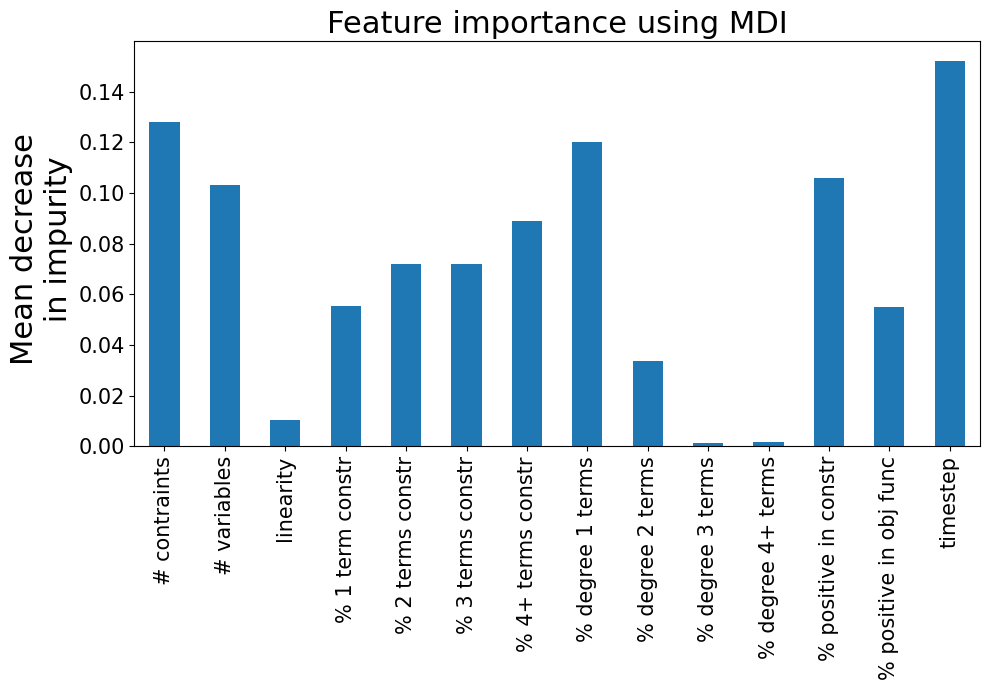

In [9]:
#Grafico feature importances
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.ensemble import RandomForestClassifier

std = np.std([tree.feature_importances_ for tree in rf_model.estimators_], axis=0)

forest_importances = pd.Series(importances, index=feats)

fsize = 22

fig, ax = plt.subplots()
#forest_importances.plot.bar(yerr=std, ax=ax, figsize = (10,7), fontsize=fsize-7)
forest_importances.plot.bar(ax=ax, figsize = (10,7), fontsize=fsize-7)
plt.xticks(rotation=90, fontsize=fsize-7)
ax.set_title("Feature importance using MDI", fontsize=fsize)
ax.set_ylabel("Mean decrease \n in impurity", fontsize=fsize)
fig.tight_layout()

#print(importances)

https://data36.com/random-forest-in-python/


# Prediction Time

In [14]:
#Calcular tiempos de predicción por cada par instancia-tiempo de test
#(Correr esto se demora 1 hora aprox)

l=int(len(y_pred)/500)
t_preds=np.empty(l*500)
i=0

#prediccion
for idx in test_indx:
    #crear dataframe de solo esa instancia-timestep
    x_i = x.iloc[[idx]]
    
    #hacer predicción y medir tiempo
    start=time.time()
    y_i = rf_model.predict(np.nan_to_num(x_i.astype(np.float32)))
    tiempo=time.time()-start
    t_preds[i]=tiempo
    
    i=i+1

In [15]:
#Guardar tiempos de prediccion

print(t_preds)
f = open(main_path+"models/results-v4/pred_times/t_pred_randomForest_nonlinear-v4-no_obj_func_size.txt", "w")
np.savetxt(f, t_preds, delimiter=" ", fmt="%s")
f.close()

[0.02369356 0.0182972  0.01643324 ... 0.00870848 0.0086267  0.00857043]
